# Определение перспективного тарифа для телеком компании

## Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов
#### Тариф «Смарт»

Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

**Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.**

## Описание данных

Таблица **users** (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица **calls** (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица **messages** (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица **internet** (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица **tariffs** (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import factorial
from scipy import stats as st

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

### Посмотрим на каждый датасет в отдельности

### Calls

In [3]:
calls.sample(10)

,id,call_date,duration,user_id
6677,1018_465,2018-09-18,3.57,1018
1923,1005_520,2018-10-06,14.67,1005
126897,1325_278,2018-06-23,6.99,1325
17135,1047_177,2018-12-05,13.62,1047
144343,1364_55,2018-11-21,7.76,1364
9257,1024_288,2018-12-08,0.00,1024
177027,1436_472,2018-08-12,7.19,1436
105123,1270_115,2018-08-21,0.24,1270
122131,1315_154,2018-07-30,16.74,1315
95456,1243_103,2018-09-16,13.64,1243


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Пропусков не обнаружено

In [5]:
calls.duplicated().sum()

0

Дубликатов не обнаружено

In [6]:
calls.describe()

,duration,user_id
count,"202,607.00","202,607.00"
mean,6.76,"1,253.94"
std,5.84,144.72
min,0.00,"1,000.00"
25%,1.30,"1,126.00"
50%,6.00,"1,260.00"
75%,10.70,"1,379.00"
max,38.00,"1,499.00"


Вывод по calls, нам необходимо:
- перевести значения в столбце call_date в date_time из object
- изменить название столбца duration в duration_m для удобства работы + решить что-то с 0 значениями, возможно мы их заменим или удалим, решим позже
- округлить значения в duration и перевести в int
- перевести в int id звонка

### Internet

In [7]:
internet.sample(10)

,Unnamed: 0,id,mb_used,session_date,user_id
64157,64157,1219_64,168.24,2018-03-26,1219
142071,142071,1476_273,535.89,2018-09-08,1476
141625,141625,1475_348,379.04,2018-06-27,1475
83512,83512,1283_103,770.01,2018-10-08,1283
125146,125146,1421_331,213.14,2018-11-08,1421
112384,112384,1380_513,381.74,2018-09-15,1380
120149,120149,1404_244,389.23,2018-12-10,1404
49466,49466,1171_168,283.56,2018-09-16,1171
68214,68214,1231_163,255.56,2018-07-17,1231
49645,49645,1171_347,0.00,2018-12-08,1171


In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Пропусков не обнаружено

In [9]:
internet.duplicated().sum()

0

Дубликатов не обнаружено

In [10]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,"149,396.00","149,396.00","149,396.00"
mean,"74,697.50",370.19,"1,252.10"
std,"43,127.05",278.30,144.05
min,0.00,0.00,"1,000.00"
25%,"37,348.75",138.19,"1,130.00"
50%,"74,697.50",348.01,"1,251.00"
75%,"112,046.25",559.55,"1,380.00"
max,"149,395.00","1,724.83","1,499.00"


Вывод по internet, необходимо:
- перевести session_date в datetime
- округлить mb_used и перевести в int
- удалить не понятный столбец unnamed: 0 
- перевести в целочисленный тип id

### Messages

In [11]:
messages.sample(10)

,id,message_date,user_id
103069,1421_32,2018-07-12,1421
28216,1122_39,2018-11-09,1122
108130,1433_737,2018-12-13,1433
19675,1087_73,2018-10-07,1087
85040,1356_57,2018-05-26,1356
25511,1104_703,2018-07-12,1104
1317,1004_371,2018-06-16,1004
105181,1425_425,2018-07-26,1425
20091,1089_94,2018-10-29,1089
9017,1035_252,2018-11-20,1035


In [12]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Пропусков не обнаружено

In [13]:
messages.duplicated().sum()

0

Дубликатов не обнаружено

Вывод по messages, необходимо:
- перевести message_date в datetime
- перевести id сообщения в int

### Tariffs

In [14]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [15]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Вывод по tariffs:
- все ок :)

### Users

In [16]:
users.sample(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
488,1488,47,NaN,Новороссийск,Вадим,Филатов,2018-11-07,smart
455,1455,38,NaN,Балашиха,Рубен,Авринский,2018-03-22,ultra
262,1262,21,NaN,Ульяновск,Антонина,Ларина,2018-03-17,smart
221,1221,40,NaN,Белгород,Джемма,Сафонова,2018-06-03,smart
309,1309,28,NaN,Казань,Юлия,Касьянова,2018-10-05,ultra
280,1280,53,NaN,Астрахань,Артемий,Худяков,2018-07-18,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
296,1296,60,NaN,Москва,Альфред,Черный,2018-06-05,smart
343,1343,30,2018-10-28,Кострома,Анита,Верещагина,2018-08-15,ultra
304,1304,68,NaN,Владимир,Илья,Соловьёв,2018-11-05,ultra


In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Есть пропуски, но смотрим описание задачи - там сказано:

"churn_date - дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)".

Оставим данные в этом столбце как есть - для решения поставленной задачи они нам не нужны.

In [18]:
users.duplicated().sum()

0

Дубликатов не обнаружено

In [19]:
users.describe()

,user_id,age
count,500.00,500.00
mean,"1,249.50",46.59
std,144.48,16.67
min,"1,000.00",18.00
25%,"1,124.75",32.00
50%,"1,249.50",46.00
75%,"1,374.25",62.00
max,"1,499.00",75.00


Вывод по users, необходимо:

- изменить reg_date в date_time и chrun_date

### Вывод:
**Calls**:
- перевести значения в столбце call_date в date_time из object
- в duration решить что-то с 0 значениями, возможно мы их заменим или удалим, решим позже
- округлить значения в duration и перевести в int
- перевести в int id звонка

**Internet**:
- перевести session_date в datetime
- округлить mb_used и перевести в int
- удалить не понятный столбец unnamed: 0 
- перевести в целочисленный тип id

**Messages**:
- перевести message_date в datetime
- перевести id сообщения в int

**Tariffs**:
- все впорядке

**Users**:

- изменить reg_date и chrun_date в тип datetime 

## Шаг 2. Подготовьте данные

**Calls**:
- перевести значения в столбце call_date в date_time из object
- в duration решить что-то с 0 значениями, возможно мы их заменим или удалим, решим позже
- округлить значения в duration и перевести в int
- перевести в int id звонка

In [20]:
calls.head(1)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000


In [21]:
#изменим тип данных в datetime в call_date
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")

In [22]:
#проверим
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [23]:
#посчитаем количество строк с 0 
calls.query('duration == 0').count()

id           39613
call_date    39613
duration     39613
user_id      39613
dtype: int64

In [24]:
#округлим вверх и переведем в целочисленный тип
calls['duration'] = calls['duration'].apply(np.ceil).astype(int)

In [25]:
#значений много, заменим на 1, так как исходя из условий даже если был звонок в 1 секунду, будем считать за минуту
calls['duration'] = calls['duration'].replace(0, 1)

In [26]:
#проверим замену 
calls.query('duration == 0').count()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [27]:
#переведем id в целочисленный тип
calls['id'] = calls['id'].astype(int)

In [28]:
#проверим тип данных
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null int64
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.2 MB


In [29]:
calls.sample(5)

,id,call_date,duration,user_id
37782,1094402,2018-07-16,5,1094
185887,145924,2018-10-27,5,1459
185251,1458543,2018-04-02,13,1458
83047,1207194,2018-11-28,6,1207
116967,1300363,2018-12-03,1,1300


**Internet**:
- перевести session_date в datetime
- округлить mb_used и перевести в int
- удалить не понятный столбец unnamed: 0 
- перевести в целочисленный тип id

In [30]:
internet.head(1)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000


In [31]:
#изменим тип данных в datetime в call_date
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")

In [32]:
#округлим и переведем в целочисленный тип 
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype(int)

In [33]:
#переведем id в целочисленный тип
internet['id'] = internet['id'].astype(int)

In [34]:
#проверим
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null int64
mb_used         149396 non-null int64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), int64(4)
memory usage: 5.7 MB


In [35]:
#удалим непонятный столбец
del internet['Unnamed: 0']

In [36]:
#проверим
internet.head(1)

,id,mb_used,session_date,user_id
0,10000,113,2018-11-25,1000


**Messages:**

- перевести message_date в datetime
- перевести id сообщения в int

In [37]:
messages.head(1)

,id,message_date,user_id
0,1000_0,2018-06-27,1000


In [38]:
#изменим тип данных в datetime в message_date
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")

In [39]:
#изменим тип данных в id на int
messages['id'] = messages['id'].astype(int)

In [40]:
#проверим
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null int64
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.8 MB


**Users**:

- изменить reg_date и chrun_date в тип date_time 

In [41]:
users.head(1)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [42]:
#изменим тип данных на datetime в reg_date и chrun_date
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d")
users['churn_date'] = pd.to_datetime(users['churn_date'], format="%Y-%m-%d")

In [43]:
#проверим 
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


## Посчитайте для каждого пользователя:

- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

#### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [44]:
calls.head(1)

,id,call_date,duration,user_id
0,10000,2018-07-25,1,1000


In [45]:
#вынесем в отдельный столбец номер месяца
calls['month'] = calls['call_date'].dt.month

In [46]:
#проверим
calls.head()

,id,call_date,duration,user_id,month
0,10000,2018-07-25,1,1000,7
1,10001,2018-08-17,1,1000,8
2,10002,2018-06-11,3,1000,6
3,10003,2018-09-21,14,1000,9
4,10004,2018-12-15,6,1000,12


In [47]:
#сгрупируем по месяцам и посчитаем количество и сумму
calls_user = calls.groupby(['user_id', 'month'])\
                  .agg({'duration':'sum', 'id':'count'})\
                  .reset_index()\
                  .rename(columns={'duration':'month_calls_duration','id':'calls_total_in_month'})
calls_user.head()

,user_id,month,month_calls_duration,calls_total_in_month
0,1000,5,164,22
1,1000,6,187,43
2,1000,7,346,47
3,1000,8,418,52
4,1000,9,478,58


#### Количество отправленных сообщений по месяцам

In [48]:
messages.head(1)

,id,message_date,user_id
0,10000,2018-06-27,1000


In [49]:
#вынесем в отдельный столбец номер месяца
messages['month'] = messages['message_date'].dt.month

In [50]:
#проверим 
messages.head()

,id,message_date,user_id,month
0,10000,2018-06-27,1000,6
1,10001,2018-10-08,1000,10
2,10002,2018-08-04,1000,8
3,10003,2018-06-16,1000,6
4,10004,2018-12-05,1000,12


In [51]:
#сгрупируем по месяцам и посчитаем количество 
messages_user = messages.groupby(['user_id', 'month'])\
                        .agg({'id':'count'})\
                        .reset_index()\
                        .rename(columns={'id':'sms_total_in_month'})
messages_user.head()

,user_id,month,sms_total_in_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


#### Объем израсходованного интернет-трафика по месяцам

In [52]:
internet.head(1)

,id,mb_used,session_date,user_id
0,10000,113,2018-11-25,1000


In [53]:
#выделим в отдельный столбец месяц
internet['month'] = internet['session_date'].dt.month

In [54]:
#проверим
internet.head()

,id,mb_used,session_date,user_id,month
0,10000,113,2018-11-25,1000,11
1,10001,1053,2018-09-07,1000,9
2,10002,1198,2018-06-25,1000,6
3,10003,551,2018-08-22,1000,8
4,10004,303,2018-09-24,1000,9


In [55]:
#сгрупируем по месяцам и посчитаем количество 
internet_user = internet.groupby(['user_id', 'month'])\
                        .agg({'mb_used':'sum'})\
                        .reset_index()\
                        .rename(columns={'mb_used':'mb_total_in_month'})
internet_user.head()

,user_id,month,mb_total_in_month
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581


#### Помесячную выручку с каждого пользователя по месяцам 

In [56]:
#соединим 3 полученные таблицы
df = calls_user.merge(messages_user, on=['user_id','month'], how='outer')

In [57]:
df = df.merge(internet_user, on=['user_id','month'], how='outer')

In [58]:
#проверим
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month
0,1000,5,164.00,22.00,22.00,"2,256.00"
1,1000,6,187.00,43.00,60.00,"23,257.00"
2,1000,7,346.00,47.00,75.00,"14,016.00"
3,1000,8,418.00,52.00,81.00,"14,070.00"
4,1000,9,478.00,58.00,57.00,"14,581.00"


In [59]:
#смержим с таблицей юзеров 
df = df.merge(users, on='user_id', how='left')

In [60]:
#проверим
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,164.00,22.00,22.00,"2,256.00",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,187.00,43.00,60.00,"23,257.00",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,346.00,47.00,75.00,"14,016.00",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,418.00,52.00,81.00,"14,070.00",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,478.00,58.00,57.00,"14,581.00",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [61]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [62]:
#изменим название столбца, что бы в дальнейшем соединить таблицы, в нач
tariffs.rename(columns={'tariff_name': 'tariff'}, inplace=True)
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,164.00,22.00,22.00,"2,256.00",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,187.00,43.00,60.00,"23,257.00",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,346.00,47.00,75.00,"14,016.00",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,418.00,52.00,81.00,"14,070.00",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,478.00,58.00,57.00,"14,581.00",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [63]:
#смержим с таблицей тарифов
df = df.merge(tariffs, on='tariff', how='left')

In [64]:
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,164.00,22.00,22.00,"2,256.00",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,187.00,43.00,60.00,"23,257.00",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,346.00,47.00,75.00,"14,016.00",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,418.00,52.00,81.00,"14,070.00",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,478.00,58.00,57.00,"14,581.00",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [65]:
#визуально видно пропуски, проверим
df.isna().sum()

user_id                     0
month                       0
month_calls_duration       40
calls_total_in_month       40
sms_total_in_month        497
mb_total_in_month          11
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [66]:
#логично предположить, что есть пользователи которые не используют смс и интернет, поставим им 0 
df['sms_total_in_month'] = df['sms_total_in_month'].fillna(0)
df['mb_total_in_month'] = df['mb_total_in_month'].fillna(0)
df['month_calls_duration'] = df['month_calls_duration'].fillna(0)
df['calls_total_in_month'] = df['calls_total_in_month'].fillna(0)

In [67]:
#проверим 
df.isna().sum()

user_id                     0
month                       0
month_calls_duration        0
calls_total_in_month        0
sms_total_in_month          0
mb_total_in_month           0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [68]:
#проверим на дубликаты полученный датафрейм
df.duplicated().sum()

0

**Вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).**

In [69]:
#напишем для этого функцию
def above_the_tariff(row):
    messages = (row['sms_total_in_month'] - row['messages_included']) * row['rub_per_message']
    minutes = (row['month_calls_duration'] - row['minutes_included']) * row['rub_per_minute']
    mbs = np.ceil(((row['mb_total_in_month'] - row['mb_per_month_included']) * row['rub_per_gb']) / 1024)
    total = 0
    for i in [messages, minutes, mbs]:
        if i > 0:
            total += i
    return total

In [70]:
#создадим столбец свыше тарифа.и завернем в apply нашу функцию
df['above_the_tariff'] = df.apply(lambda x: above_the_tariff(x), axis=1)

In [71]:
#создадим столбец столбец общей суммы
df['total_paid'] = df['rub_monthly_fee'] + df['above_the_tariff']

In [72]:
df.sort_values(by='total_paid').sample(10)

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,above_the_tariff,total_paid
880,1143,9,650.00,85.00,0.00,"22,701.00",64,NaT,Пермь,Арсен,Покровский,2018-04-27,ultra,1000,30720,3000,1950,150,1,1,0.00,"1,950.00"
214,1033,9,422.00,58.00,77.00,"25,895.00",71,NaT,Москва,Лия,Бабушкина,2018-07-15,smart,50,15360,500,550,200,3,3,"2,139.00","2,689.00"
2797,1437,10,309.00,50.00,14.00,"18,498.00",73,NaT,Казань,Лилия,Селезнева,2018-08-03,smart,50,15360,500,550,200,3,3,613.00,"1,163.00"
118,1016,12,99.00,16.00,103.00,"19,446.00",58,NaT,Омск,Марица,Сазонова,2018-11-21,ultra,1000,30720,3000,1950,150,1,1,0.00,"1,950.00"
288,1046,9,520.00,72.00,34.00,"15,910.00",72,NaT,Тула,Екатерина,Александрова,2018-08-20,smart,50,15360,500,550,200,3,3,168.00,718.00
31,1005,2,470.00,69.00,38.00,"7,394.00",67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15360,500,550,200,3,3,0.00,550.00
1288,1204,1,314.00,50.00,0.00,"15,854.00",18,NaT,Москва,Мирослава,Лазарева,2018-01-04,smart,50,15360,500,550,200,3,3,97.00,647.00
3048,1478,8,316.00,45.00,75.00,"13,144.00",75,NaT,Грозный,Таира,Константинова,2018-07-16,smart,50,15360,500,550,200,3,3,75.00,625.00
1276,1202,11,391.00,56.00,36.00,"16,021.00",22,NaT,Владивосток,Адам,Адаменко,2018-09-20,smart,50,15360,500,550,200,3,3,130.00,680.00
1369,1217,11,509.00,66.00,58.00,"13,075.00",42,NaT,Ульяновск,Ермолай,Сазонов,2018-02-23,smart,50,15360,500,550,200,3,3,51.00,601.00


## Шаг 3. Проанализируйте данные

#### Опишите поведение клиентов оператора, исходя из выборки. 

- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 
- Посчитайте среднее количество, дисперсию и стандартное отклонение. 
- Постройте гистограммы. 
- Опишите распределения.

In [73]:
df[['above_the_tariff', 'total_paid']].describe()

,above_the_tariff,total_paid
count,"3,214.00","3,214.00"
mean,519.79,"1,498.85"
std,744.05,786.82
min,0.00,550.00
25%,0.00,712.50
50%,123.00,"1,589.50"
75%,856.50,"1,950.00"
max,"6,216.00","6,766.00"


In [74]:
df['tariff'].value_counts()

smart    2229
ultra     985
Name: tariff, dtype: int64

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(0, 7000)

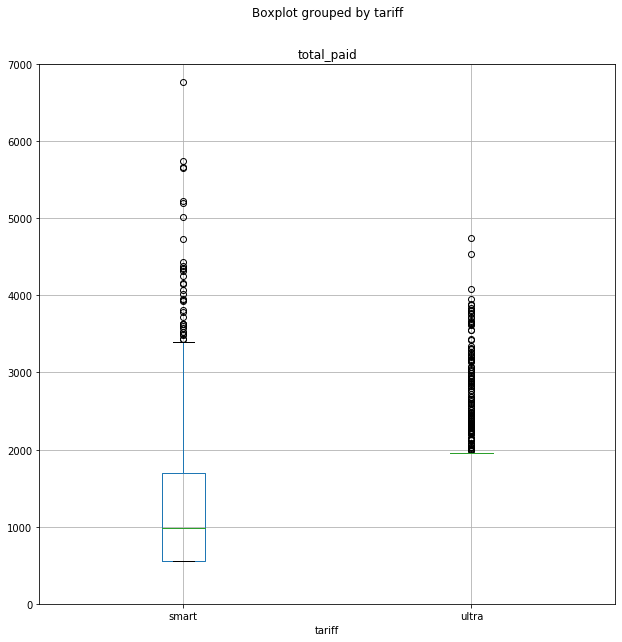

In [95]:
#построим ящик с усами
df.boxplot('total_paid', by='tariff', figsize=(10,10)).set_ylim(0,7000)

Тариф Ультра тяжело интерпритировать, посмотроим гистограмму.

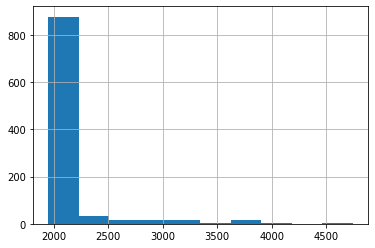

In [94]:
#тут видно четче
df[df['tariff'] == 'ultra']['total_paid'].hist()

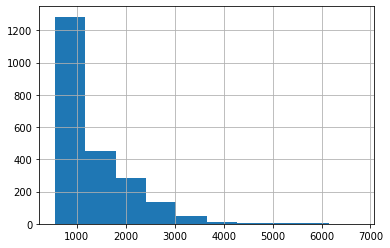

In [77]:
#со смартом все вполне нормально
df[df['tariff'] == 'smart']['total_paid'].hist()

In [92]:
df.groupby('tariff')\
  .agg({'total_paid':['count','median','mean','var','std']})\
  .style.format("{:.2f}")

Пользователи тарифа Смарт имеют довольно большое стандартное отклонение для интернета, смс и продолжительности разговоров, что говорит о большом разбросе данных. 
Услугами люди пользуются по-разному.



In [79]:
df.groupby('tariff')\
  .agg({'month_calls_duration':['count','median','mean','var','std']})\
  .style.format("{:.2f}")

Text(0.5, 1.0, 'Смарт — Звонки в минутах в месяц')

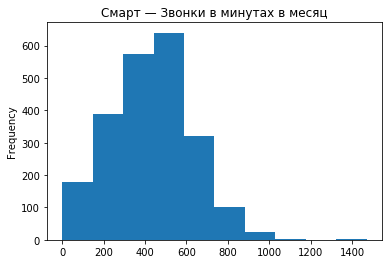

In [80]:
df[df['tariff'] == 'smart']['month_calls_duration'].plot(kind='hist', bins=10)
plt.title('Смарт — Звонки в минутах в месяц')

Text(0.5, 1.0, 'Ультра — Звонки в минутах в месяц')

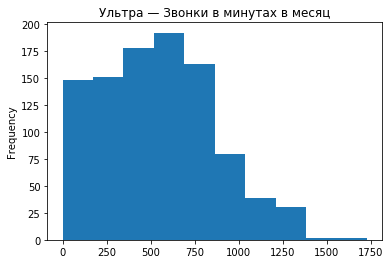

In [81]:
df[df['tariff'] == 'ultra']['month_calls_duration'].plot(kind='hist', bins=10)
plt.title('Ультра — Звонки в минутах в месяц')

На Смарте люди в месяц разговаривают в районе 450 минут, на Ультре 550 минут в месяц. На Смарте люди подходят к краю своего тарифа, а на Ультре у них остается запас 2500 минут. Среднее и медиана лежат в одном районе.

In [82]:
df.groupby('tariff')\
  .agg({'mb_total_in_month':['count','median','mean','var','std']})\
  .style.format("{:.2f}")

Text(0.5, 1.0, 'Смарт — Интернет в МБ в месяц')

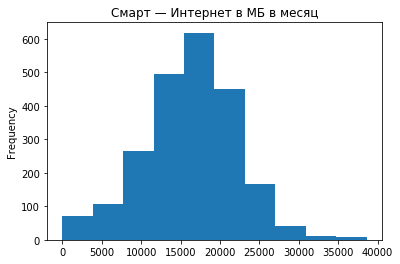

In [83]:
df[df['tariff'] == 'smart']['mb_total_in_month'].plot(kind='hist', bins=10)
plt.title('Смарт — Интернет в МБ в месяц')

Text(0.5, 1.0, 'Ультра — Интернет в МБ в месяц')

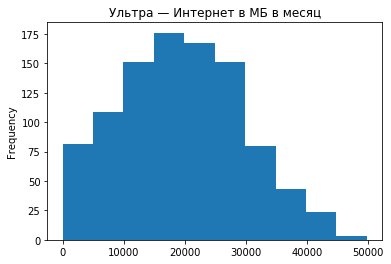

In [84]:
df[df['tariff'] == 'ultra']['mb_total_in_month'].plot(kind='hist', bins=10)
plt.title('Ультра — Интернет в МБ в месяц')

Среднее и медиана лежат в одном районе. На Смарте люди выходят за пределы тарифа больше, у Ультры есть запас

In [85]:
df.groupby('tariff')\
  .agg({'sms_total_in_month':['count','median','mean','var','std']})\
  .style.format("{:.2f}")

Text(0.5, 1.0, 'Смарт — СМС в месяц')

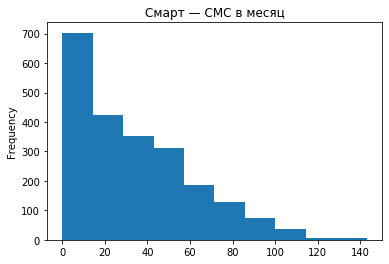

In [86]:
df[df['tariff'] == 'smart']['sms_total_in_month'].plot(kind='hist', bins=10)
plt.title('Смарт — СМС в месяц')

Text(0.5, 1.0, 'Ультра — СМС в месяц')

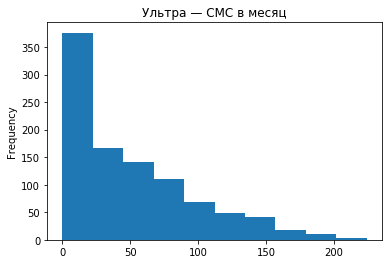

In [87]:
df[df['tariff'] == 'ultra']['sms_total_in_month'].plot(kind='hist', bins=10)
plt.title('Ультра — СМС в месяц')

Поведение пользователей выглядит похожим. Сообщениями пользуются мало.

### Вывод:
#### Построили боксплот, гистограммы, ознакомились с данными и сделали следующие выводы:

- Пользователи тарифа Смарт имеют довольно большое стандартное отклонение для интернета, смс и продолжительности разговоров, что говорит о большом разбросе данных. Услугами люди пользуются по-разному;


- На Смарте люди в месяц разговаривают в районе 450 минут, на Ультре 550 минут в месяц. На Смарте люди подходят к краю своего тарифа, а на Ультре у них остается запас 2500 минут. Среднее и медиана лежат в одном районе;


- На Смарте интернетом пользуются больше и выходят за пределы тарифа, у Ультры есть запас в районе 10к мб;


- СМС почти никто не использует, среднее и медиана практически одинаковая.


## Шаг 4. Проверьте гипотезы

1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Поясните:
- как вы формулировали нулевую и альтернативную гипотезы;
- какой критерий использовали для проверки гипотез и почему.

**Сформулируем гипотезы:**

- Н0 --- Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны, т.е. средние значения равны.
- Н1 ---  Средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны, т.е. средние значения не равны.

In [96]:
alpha = .05

ultra = df.query('tariff == "ultra"')['total_paid']
smart = df.query('tariff == "smart"')['total_paid']

result = st.ttest_ind(ultra, smart, equal_var=False)

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 5.483966187394131e-282
Отвергаем нулевую гипотезу


Странно, что pvalue 0, но тарифы действительно имеют существенные различия

**Сформулируем гипотезы:**

H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов

H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [89]:
df['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Курган', 'Барнаул', 'Красноярск', 'Архангельск', 'Липецк',
       'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Волжский', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [97]:
alpha = .05

moscow = df.query('city == "Москва"')['total_paid']
other = df.query('city != "Москва"')['total_paid']

result = st.ttest_ind(moscow, other, equal_var=False)

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 0.5018877334164041
Не отвергаем нулевую гипотезу


Мы не отвергаем нуловую гипотезу о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов, т.е. средние значения не равны.

## Шаг 5. Напишите общий вывод

- Люди на разных тарифах ведут себя по-разному, что наверно и хорошо. Так и должно работать сегментирование. Но и переплачивают, а это, особенно в Смарте, может приводить к разочарованию и оттоку


- СМС-ки никому не нужны на обоих тарифах. Но если в Смарте люди близки к своим лимитам, то на Ультре остаются большие неизрасходованные "запасы" — возможно, имеет смысл подумать, как использовать эту, по сути, упущенную выгоду


- Деньги одинаково текут и из регионов и из Москвы, и вероятно это не связано с уровнем жизни, а с поведением: ~8-10 часов в месяц — это предел у среднего клиента на обоих тарифах


- Тарифы приносят разные деньги, значимые различия есть


- Люди с тарифом Ультра не израсходуют свой лимит входящий в тариф.


- Отвергаем гипотезу о том, что выручка пользователей тарифов «Ультра» и «Смарт» не различается, т.е. средние значения равны.


- Мы не отвергаем гипотезу о том, что что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов т.е. средние значения не равны.

**Рекомендации оператору:**
    
- Исправить округление — нулевые минуты должны округляться до 1
- Не публиковать незашифрованные ФИО и города в одном наборе
- Подумать над оптимизацией тарифов